# Summary:

#### In this notebook, the trial runs from the preceding notebook ('01_So_What.ipynb') are systematically extended to try to find an optimal configuration for the two models. The model parameters to be fine tuned are: number of epochs, number of layers and the number of units.

#### The best performing model configuration will be used in the notebook '03_Blue_in_Green.ipynb' to analyze the impact of adding noise to the clean dataset.


# Table of contents
* [1. Load modules](#Part1_link)
* [2. Setup data](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1  Clean data](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2  Add noise](#Part2.2_link)
* [3. Setup models and evaluate for various hyper-parameter choices](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Compile and fit LSTM and RNN model](#Part3.1_link)
* [4. Visualize results](#Part4_link)

<a id='Part1_link'></a>
# 1. Load modules

In [1]:
import sys
sys.path.append("../src/")
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
import copy


<a id='Part2_link'></a>
# 2. Download data

<a id='Part2.1_link'></a>
### 2.1 Load historical stock data and store locally

In [2]:
# # get historical daily stock data from yahoo finance and store locally
# start_dt = '2015-01-01'
# end_dt = '2020-01-01'

# data_EWZ = yf.download('EWZ', start_dt, end_dt)
# data_BRZU = yf.download('BRZU', start_dt, end_dt)

# # Import the plotting library
# import matplotlib.pyplot as plt
# %matplotlib inline

# # Plot the close price of the AAPL
# data_EWZ['Adj Close'].plot()
# plt.show()

# data_EWZ.to_csv("../data/05_EWZ_data.csv")
# data_BRZU.to_csv("../data/05_BRZU_data.csv")

<a id='Part2.2_link'></a>
### 2.2 Load locally stored data

In [3]:
# load locally stored ETF data
df_EWZ = pd.read_csv("../data/05_EWZ_data.csv", index_col='Date')
df_BRZU = pd.read_csv("../data/05_BRZU_data.csv", index_col='Date')

df_EWZ.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,35.980000,36.000000,35.040001,35.360001,30.774229,17765400
2015-01-05,34.220001,34.410000,34.049999,34.150002,29.721155,22200400
2015-01-06,34.619999,34.990002,34.209999,34.759998,30.252037,21194000
2015-01-07,35.750000,36.099998,35.520000,35.700001,31.070141,16427500
2015-01-08,35.939999,36.570000,35.799999,36.270000,31.566212,14081000


In [4]:
df_BRZU.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2954.0,2954.0,2712.5,2793.0,2691.072998,800
2015-01-05,2513.0,2562.0,2485.0,2502.5,2411.174561,1000
2015-01-06,2597.0,2670.5,2520.0,2639.0,2542.693115,300
2015-01-07,2870.0,2933.0,2814.0,2838.5,2734.912354,400
2015-01-08,2901.5,3055.5,2870.0,2992.5,2883.292725,700


<a id='Part3_link'></a>
# 3. Exploratory data analysis

feature engineering:
To get an indicator for the intra-day volatility, the maximum drawdown as the difference of High (price) and Low (price) is taken and divided by the Open (price). This new feature is called 'Drawdown'

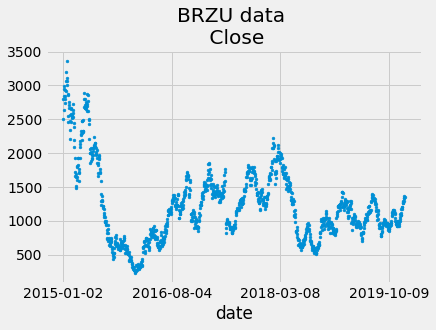

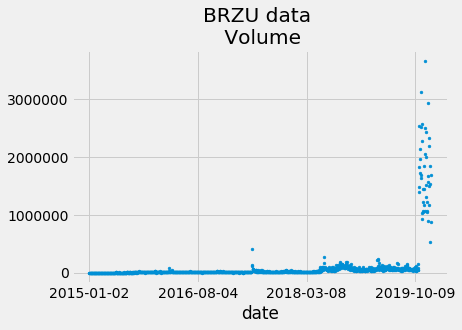

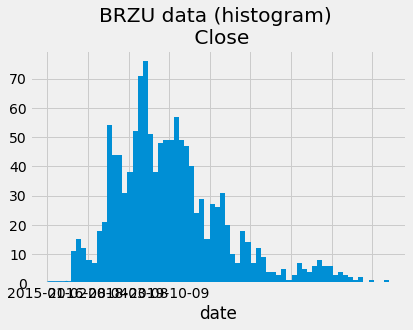

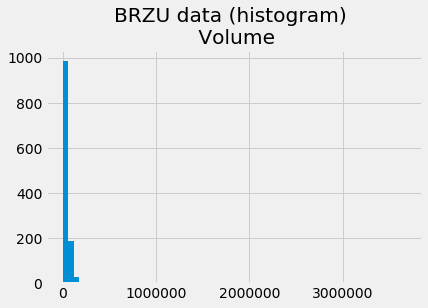

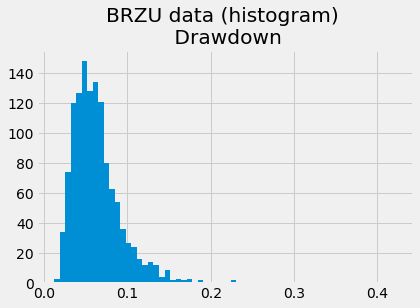

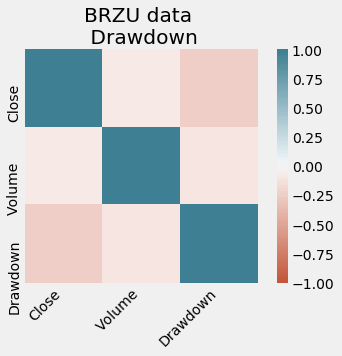

In [5]:
# run below cells for either EWZ or BRZU dataframe

# df, df_name = df_EWZ, 'EWZ'
df, df_name = df_BRZU, 'BRZU'

df_tmp = pd.DataFrame((df['High'] - df['Low'])/df['Open'], columns=['Drawdown'])
df = df.join(df_tmp)

# drop columns that are no longer of interest
drop_cols = ['Open', 'High', 'Low', 'Adj Close']
df = df.drop(drop_cols, axis=1)

# plot results
size = 8
tick_spacing = 400
width = 1

# scatter plots
for col in df.columns:
    fig, ax = plt.subplots(1,1)
    
    x = [x for x in df.index]
    y = [x for x in list(df[col])]
    
    ax.scatter(x, y, s=size)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    ax.set_xlabel('date')
    ax.set_title('{} data \n {}'.format(df_name, col))
    
# histograms
bins = int(len(df)/20)

for col in df.columns:
    df[col].hist(bins=bins)
    plt.title('{} data (histogram) \n {}'.format(df_name, col))
    plt.show()
    plt.close()
    
# correlation
corr = df.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0
                 , cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_title('{} data \n {}'.format(df_name, col))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


Text(0.5, 1.0, 'BRZU data: Close Prices \n monthly trend decomposition')

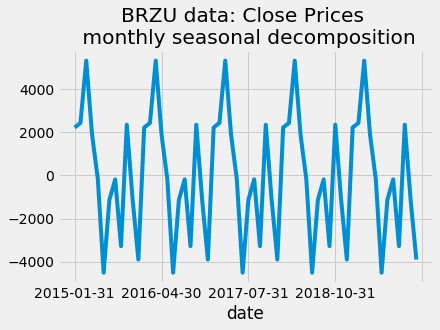

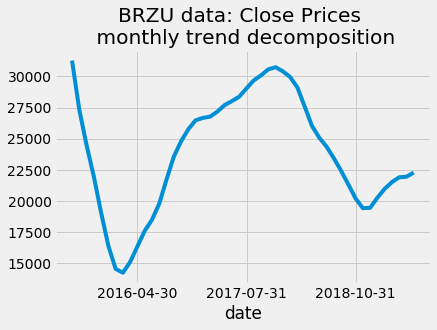

In [6]:
# seasonal decomposition plots

df_tmp = copy.deepcopy(df)

df_tmp.index = pd.to_datetime(df_tmp.index)  # make index a pandas timestamp

# resample data to monthly sums
resampling_period = 'M'
df_tmp = df_tmp.resample(resampling_period).sum()


# get seasonal decomposition plots on Close price
a = seasonal_decompose(df_tmp['Close'], model='add')

# plot data
size = 8
tick_spacing = 15
width = 1

# plot seasonal data
fig, ax = plt.subplots(1, 1)

x = [str(x)[:10] for x in a.seasonal.index]
y = [x for x in list(a.seasonal.values)]

ax.plot(x, y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.set_xlabel('date')
ax.set_title('{} data: Close Prices \n {}'.format(df_name, 'monthly seasonal decomposition'))

# plot trend data
fig, ax = plt.subplots(1, 1)
x = [str(x)[:10] for x in a.trend.index]
y = [x for x in list(a.trend.values)]

ax.plot(x, y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.set_xlabel('date')
ax.set_title('{} data: Close Prices \n {}'.format(df_name, 'monthly trend decomposition'))


<a id='Part3_link'></a>
# 3. Compile and fit models

<a id='Part3.1_link'></a>
### 3.1 Setup framework

In [7]:
# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# load dataframe into object
mdq._selected_features = ['Close']
mdq.df = df.drop('Volume', axis=1)  # drop Volume information

# initialize dataset from dataframe 
mdq.initialize_dataset()

# standardize data
mdq.standardize_data()

# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)

# model configuration
units = 128  # number of units in each neural network layer
num_layers = 2  # total number of layers
epochs = 50


<a id='Part3.2_link'></a>
### 3.2 Train and validate model

In [8]:
# choose a few past history sizes
past_history_sizes = [10 * future_target_size, 30 * future_target_size, 52 * future_target_size]

# initialize results dictionary
res_2 = {'model_type': [], 'past_history_size': [], 'val_mse': []
       , 'mse': [], 'total_training_time': []}

# model type 
model_types = ['RNN', 'LSTM']

for model_type in model_types:
    
    for past_history_size in past_history_sizes:
        
        # generate train and validation data
        mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)

        # set number of steps per epoch
        num_samples = mdq._num_samples
        steps_per_epoch = int(num_samples/future_target_size)
        validation_steps = int(steps_per_epoch/2)

        # compile model
        mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

        # fit model
        mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
                      ,validation_steps=validation_steps, model_type=model_type)

        # get errors
        history = mdq._histories[model_type]
        val_mse = history.history['val_mse'][-1]
        mse = history.history['mse'][-1]

        # get total training time
        total_training_time = sum(mdq._time_callbacks[model_type].times)

        # append results to results dictionary
        res_2['model_type'].append(model_type)
        res_2['past_history_size'].append(past_history_size)
        res_2['val_mse'].append(val_mse)
        res_2['mse'].append(mse)
        res_2['total_training_time'].append(total_training_time)

training set shape: x:(810, 70, 1), y:(810, 7, 1)
validation set shape: x:(301, 70, 1), y:(301, 7, 1)
Epoch 1/50
115/115 [==============================] - 2s 16ms/step - loss: 0.1185 - mse: 0.1185 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 2/50
115/115 [==============================] - 2s 14ms/step - loss: 0.0773 - mse: 0.0773 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 3/50
115/115 [==============================] - 2s 14ms/step - loss: 0.0744 - mse: 0.0744 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 4/50
115/115 [==============================] - 2s 15ms/step - loss: 0.0677 - mse: 0.0677 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 5/50
115/115 [==============================] - 2s 14ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 6/50
115/115 [==============================] - 2s 14ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 7/50
115/115 [==============================] - 2s 15ms/step - loss: 0.0675 - mse: 0.0675 - va

Epoch 11/50
95/95 [==============================] - 4s 40ms/step - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 12/50
95/95 [==============================] - 4s 38ms/step - loss: 0.5239 - mse: 0.5239 - val_loss: 3.6982 - val_mse: 3.6982
Epoch 13/50
95/95 [==============================] - 4s 40ms/step - loss: 0.6416 - mse: 0.6416 - val_loss: 0.0720 - val_mse: 0.0720
Epoch 14/50
95/95 [==============================] - 4s 41ms/step - loss: 0.3937 - mse: 0.3937 - val_loss: 0.0877 - val_mse: 0.0877
Epoch 15/50
95/95 [==============================] - 4s 38ms/step - loss: 0.1361 - mse: 0.1361 - val_loss: 0.0387 - val_mse: 0.0387
Epoch 16/50
95/95 [==============================] - 4s 39ms/step - loss: 0.0861 - mse: 0.0861 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 17/50
95/95 [==============================] - 4s 37ms/step - loss: 0.0824 - mse: 0.0824 - val_loss: 0.0759 - val_mse: 0.0759
Epoch 18/50
95/95 [==============================] - 4s 43ms/step - loss: 0.

73/73 [==============================] - 5s 73ms/step - loss: 0.0793 - mse: 0.0793 - val_loss: 0.0562 - val_mse: 0.0562
Epoch 23/50
73/73 [==============================] - 5s 70ms/step - loss: 0.0732 - mse: 0.0732 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 24/50
73/73 [==============================] - 5s 68ms/step - loss: 0.0704 - mse: 0.0704 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 25/50
73/73 [==============================] - 6s 76ms/step - loss: 0.0641 - mse: 0.0641 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 26/50
73/73 [==============================] - 6s 77ms/step - loss: 0.0590 - mse: 0.0590 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 27/50
73/73 [==============================] - 5s 72ms/step - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 28/50
73/73 [==============================] - 5s 74ms/step - loss: 0.0549 - mse: 0.0549 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 29/50
73/73 [==============================] - 5s 72ms/step - loss: 0.0579 - mse: 

115/115 [==============================] - 8s 71ms/step - loss: 0.8093 - mse: 0.8093 - val_loss: 0.1880 - val_mse: 0.1880
Epoch 33/50
115/115 [==============================] - 10s 83ms/step - loss: 0.8009 - mse: 0.8009 - val_loss: 0.1874 - val_mse: 0.1874
Epoch 34/50
115/115 [==============================] - 8s 72ms/step - loss: 0.8392 - mse: 0.8392 - val_loss: 0.1868 - val_mse: 0.1868
Epoch 35/50
115/115 [==============================] - 8s 69ms/step - loss: 0.7961 - mse: 0.7961 - val_loss: 0.1861 - val_mse: 0.1861
Epoch 36/50
115/115 [==============================] - 8s 65ms/step - loss: 0.7959 - mse: 0.7959 - val_loss: 0.1855 - val_mse: 0.1855
Epoch 37/50
115/115 [==============================] - 9s 77ms/step - loss: 0.7960 - mse: 0.7960 - val_loss: 0.1849 - val_mse: 0.1849
Epoch 38/50
115/115 [==============================] - 8s 69ms/step - loss: 0.8191 - mse: 0.8191 - val_loss: 0.1842 - val_mse: 0.1842
Epoch 39/50
115/115 [==============================] - 10s 85ms/step - lo

95/95 [==============================] - 21s 222ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 47/50
95/95 [==============================] - 21s 222ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 48/50
95/95 [==============================] - 27s 286ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 49/50
95/95 [==============================] - 25s 259ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 50/50
95/95 [==============================] - 23s 241ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
training set shape: x:(516, 364, 1), y:(516, 7, 1)
validation set shape: x:(7, 364, 1), y:(7, 7, 1)
Epoch 1/50
73/73 [==============================] - 27s 368ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/50
73/73 [==============================] - 28s 386ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/50
73/73 [==============================] - 28s 377m

<a id='Part4_link'></a>
# 4. Visualize and save results

In [9]:
# transform dictionary to dataframe
df_res_22 = pd.DataFrame(res_2)

# store dataframe as csv locally
df_res_22.to_csv('../data/05_results_{}.csv'.format(df_name))

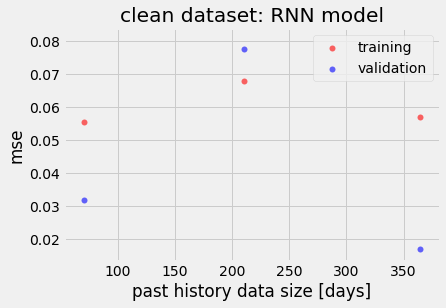

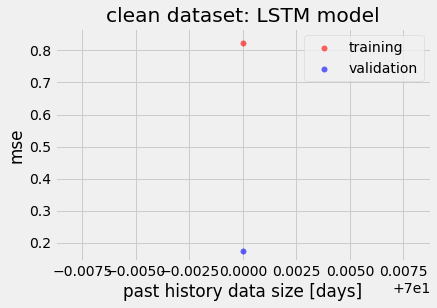

In [10]:
# visualize results
# compare RNN to LSTM results

df_res = df_res_22

x_label = 'past_history_size'
y_label = 'mse'
z_label = 'val_mse'

for model_type in model_types:
    condition_1 = (df_res['model_type']== model_type)
    
    x = df_res[condition_1][x_label].values
    y = df_res[condition_1][y_label].values
    
    z = df_res[condition_1][z_label].values
    
    plt.scatter(x, y, alpha=0.6, c="red", linewidth=0.0, label='training')
    plt.scatter(x, z, alpha=0.6, c="blue", linewidth=0.0, label='validation')
        
    plt.xlabel('past history data size [days]')
    plt.ylabel('mse')
    plt.legend()
    plt.title('clean dataset: {} model'.format(model_type))
    plt.show()